### [1.00]: Import the required modules.

In [1]:
# Import the required modules.
import os
import re
import wx  # Install it with pip.
import sys
import json
import shutil
import numpy as np
import pandas as pd
from os import path
from datetime import datetime

### [1.10]: Instantiate the ML pipeline class.

In [2]:
# Function to prompt the user to upload the file.
def get_path(wildcard):
    app = wx.App(None)
    style = wx.FD_OPEN | wx.FD_FILE_MUST_EXIST
    dialog = wx.FileDialog(None, 'Choose a training file.', wildcard=wildcard, style=style)
    if dialog.ShowModal() == wx.ID_OK:
        path = dialog.GetPath()
    else:
        path = None
    dialog.Destroy()
    return path

In [3]:
try:
    # Call the funtion to get the input files.
    s_infile = get_path('*.csv')
    s_infile = s_infile.replace("\\","\\\\")

    # Get the current working directory.
    s_path = os.getcwd()
    s_path = s_path.replace("\\","\\\\")
    s_basefile = os.path.basename(s_infile)

    # Check, if path exists in system path,else add.
    if s_path in os.environ:
        sys.path.append(s_path)

    # Instantiate and Consume the class.
    from classMLModelingPipeline import *
    # Open and read the App Configuration using json.
    with open(s_path + '\\AppConfig.txt') as json_file:
        # Load the App config details.
        data = json.load(json_file)
        # For each entry in json, extract App config parameters.
        for p in data['AppConfig']:
            applConfig = modMLModelingPipeline  (  p['Id'],
                                                    p['Name'],
                                                    p['Source'],
                                                    p['Output'],
                                                    p['TrainedModel'],
                                                    p['ExecutionLog'],
                                                    p['ExecutionLogFileName'],
                                                    p['Archive']
                                                  )
    #===== Create Application Directories ============================================================
    s_classApplication  = 'classMLModelingPipeline'
    s_classMethod       = 'CreateAppDirectories'
    s_statusType        = 'Success'
    s_statusDescription = 'Successfull write operation.'
    applConfig.CreateAppDirectories()
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )
except AttributeError:
    print("No file has been choosen!!!!")
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise

In [4]:
def GetInputFileFromSource(s_in_temp_path,s_in_filename):
    # Path to retrieve the input file.
    s_in_cwd_file = s_in_temp_path
    # Get the path to source directory from class.
    s_in_source_file = applConfig.Source
    s_in_source_file = s_in_source_file + s_in_filename
    # Check, if input file present in source.
    if os.path.isfile(s_in_source_file):
        s_inputPath = s_in_source_file
    else:
        # Copy it from cwd.
        shutil.copy(s_in_cwd_file,s_in_source_file)
    return s_in_source_file

### [1.20]: Data loading

In [5]:
# Get the input file from source.
s_inputPath = GetInputFileFromSource(s_infile,s_basefile)

# Load the data from the csv file into pandas dataframe.
dfDataVendor = pd.read_csv(s_inputPath
                         ,parse_dates = ['Doc. Date','Del Date','GRN Date']
                         ,infer_datetime_format = True
                        )
# Display the top rows.
dfDataVendor.head(2)

,POrg,Plnt,Purch.Doc.,Item,Doc. Date,Supplier/Supplying Plant,Material,Short Text,Del Date,GRN Date,Sum of PO Quantity,Sum of Net Price,Sum of PO Value,Sum of GRN Qty,Sum of GRN Val
0,1000,10,2000042605,10,2019-09-04,201020 SANVIJAY ROLLING & ENGG. LTD.,MS1-45X30X4P,MS1-45X30X4P IS-2062-E250-BLACK \ WHITE,2019-05-24,2019-05-28,10.164,41000,416724.0,10.164,416724.0
1,1000,10,2000042605,20,2019-09-04,201020 SANVIJAY ROLLING & ENGG. LTD.,MS3-40X40X4,MS3-40X40X4 : EN10025-2 235JR (R/B),2019-05-24,2019-05-24,70.560,82000,2892960.0,35.623,1460543.0


### [1.30]: Data pre-processing.

#### [1.31]: Extract VendorCode.

In [6]:
# Extract VendorCode from "Supplier/Supplying Plant" column.
dfDataVendor['VendorCode']  = dfDataVendor['Supplier/Supplying Plant'].str.extract('(\d+)')
# Alternate way:
#dfDataVendor['VendorCode']  = dfDataVendor['Supplier/Supplying Plant'].str.extract('([0-9][0-9][0-9][0-9][0-9][0-9]+)')

#### [1.32]: Inspect datatypes.

In [7]:
# Check the datatypes of the dataframe.
dfDataVendor.dtypes

POrg                                 int64
Plnt                                 int64
Purch.Doc.                           int64
Item                                 int64
Doc. Date                   datetime64[ns]
Supplier/Supplying Plant            object
Material                            object
Short Text                          object
Del Date                    datetime64[ns]
GRN Date                    datetime64[ns]
Sum of PO Quantity                 float64
Sum of      Net Price                int64
Sum of PO Value                    float64
Sum of GRN Qty                     float64
Sum of GRN Val                     float64
VendorCode                          object
dtype: object

#### [1.33]: Export data cleansed, so far to .csv format for inspection.

In [8]:
# Export the date columns to a csv file and manually inspect for anamolies.
dfDataVendor[['GRN Date','Doc. Date','Del Date','VendorCode']].to_csv('Data_Inspect.csv')

#### [1.33]: Get the latest data for multiple vendor occurence for the given snapshot.

In [9]:
dfDataVendorMaxDate = dfDataVendor.groupby(['Material','VendorCode']).agg({'Doc. Date':'max'}) \
                      .reindex(['Doc. Date'], axis=1) \
                      .reset_index()

dfDataVendorLatest = pd.merge(dfDataVendor,dfDataVendorMaxDate,on=['Material','VendorCode','Doc. Date'],how='inner')

In [10]:
dfDataVendorLatest.columns

Index(['POrg', 'Plnt', 'Purch.Doc.', 'Item', 'Doc. Date',
       'Supplier/Supplying Plant', 'Material', 'Short Text', 'Del Date',
       'GRN Date', 'Sum of PO Quantity', 'Sum of      Net Price',
       'Sum of PO Value', 'Sum of GRN Qty', 'Sum of GRN Val', 'VendorCode'],
      dtype='object')

#### [1.34]: Calculate the deviation metrics.

In [11]:
# Deviation in expected vs actual delivery dates.
dfDataVendorLatest['Deviation_DeliveryDate'] = (dfDataVendorLatest['GRN Date'] - dfDataVendorLatest['Del Date']).dt.days

# Deviation in expected vs actual delivered quantity.
dfDataVendorLatest['Deviation_DeliveredQty'] = (dfDataVendorLatest['Sum of PO Quantity'] - dfDataVendorLatest['Sum of GRN Qty']) \
/dfDataVendorLatest['Sum of PO Quantity']

# Round of to the nearest 4th decimal.
dfDataVendorLatest['Deviation_DeliveredQty'] = dfDataVendorLatest['Deviation_DeliveredQty'].round(3)

# Deviation in expected vs actual delivered value.
dfDataVendorLatest['Deviation_DeliveredValue'] = (dfDataVendorLatest['Sum of PO Value'] - dfDataVendorLatest['Sum of GRN Val']) \
/dfDataVendorLatest['Sum of PO Value']

# Round of to the nearest 4th decimal.
dfDataVendorLatest['Deviation_DeliveredValue'] = dfDataVendorLatest['Deviation_DeliveredValue'].round(3)

# Handle negative deviations in quantity and value. Delivered more qty/value than the PO contract.
dfDataVendorLatest.loc[dfDataVendorLatest['Deviation_DeliveredQty']   < 0.0,  'Deviation_DeliveredQty'] = 0.0
dfDataVendorLatest.loc[dfDataVendorLatest['Deviation_DeliveredValue'] < 0.0,'Deviation_DeliveredValue'] = 0.0

In [12]:
'''
# Deviation in expected vs actual delivered value.
dfDataVendor[['Material','VendorCode','Sum of PO Value','Sum of GRN Val','Deviation_DeliveredValue']] \
[dfDataVendor['Material'] == 'HT1-100X100X8P']

# Deviation in expected vs actual deivered quantity.
dfDataVendor[['Material','VendorCode','Sum of PO Quantity','Sum of GRN Qty','Deviation_DeliveredQty']] \
[dfDataVendor['Material'] == 'HT1-100X100X8P']

# Deviation in expected vs actual delivery dates.
dfDataVendor[['Material','VendorCode','Doc. Date','Del Date','GRN Date','Deviation_DeliveryDate']] \
[dfDataVendor['Material'] == 'HT1-100X100X8P']
# Materials supplied by multiple vendors 
# 'HT10-100X100X10','HT10-100X100X6','HT10-100X100X8','HT10-10THK','HT10-110X110X10','HT10-110X110X8'
'''

"\n# Deviation in expected vs actual delivered value.\ndfDataVendor[['Material','VendorCode','Sum of PO Value','Sum of GRN Val','Deviation_DeliveredValue']] [dfDataVendor['Material'] == 'HT1-100X100X8P']\n\n# Deviation in expected vs actual deivered quantity.\ndfDataVendor[['Material','VendorCode','Sum of PO Quantity','Sum of GRN Qty','Deviation_DeliveredQty']] [dfDataVendor['Material'] == 'HT1-100X100X8P']\n\n# Deviation in expected vs actual delivery dates.\ndfDataVendor[['Material','VendorCode','Doc. Date','Del Date','GRN Date','Deviation_DeliveryDate']] [dfDataVendor['Material'] == 'HT1-100X100X8P']\n# Materials supplied by multiple vendors \n# 'HT10-100X100X10','HT10-100X100X6','HT10-100X100X8','HT10-10THK','HT10-110X110X10','HT10-110X110X8'\n"

### [1.40]: Build the final dataframe for ML modelling.

#### [1.41]: Concatenate all the required columns.

In [14]:
# Concat all the columns required for the analysis.
dfDataVendorFinal = dfDataVendorLatest[['Doc. Date','VendorCode','Material','Deviation_DeliveryDate', \
                                 'Deviation_DeliveredQty','Deviation_DeliveredValue']]

#### [1.42]: Explore the distribution of data.

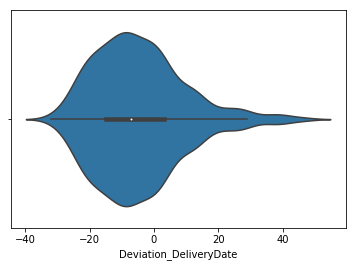

In [15]:
# For variable : "Deviation_DeliveryDate"
# Import the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Create violinplot
sns.violinplot(x = "Deviation_DeliveryDate", data=dfDataVendorFinal)

# Show the plot
plt.show()

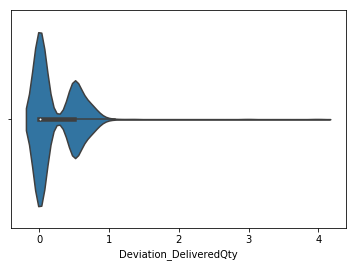

In [16]:
# For variable : "Deviation_DeliveredQty"
# Import the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Create violinplot
sns.violinplot(x = "Deviation_DeliveredQty", data=dfDataVendorFinal)

# Show the plot
plt.show()

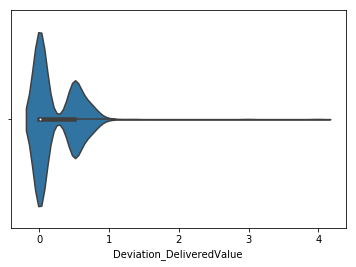

In [17]:
# For variable : "Deviation_DeliveredValue"
# Import the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Create violinplot
sns.violinplot(x = "Deviation_DeliveredValue", data=dfDataVendorFinal)

# Show the plot
plt.show()

#### [1.43]: Derive and build the class label.

In [18]:
dfDataVendorFinal['Deviation_DeliveryDate'].describe()

count    606.000000
mean      -4.717822
std       14.081624
min      -32.000000
25%      -15.000000
50%       -7.000000
75%        3.000000
max       47.000000
Name: Deviation_DeliveryDate, dtype: float64

In [19]:
dfDataVendorFinal['Deviation_DeliveredQty'].describe()

count    606.000000
mean       0.234847
std        0.344642
min        0.000000
25%        0.000000
50%        0.008000
75%        0.500000
max        3.981000
Name: Deviation_DeliveredQty, dtype: float64

In [20]:
# Function to generate the class Label.
def getClassDelivery(dfClassDelivery):
    # Store the actual index.
    dfIndex = dfClassDelivery.index
    # Set the index to 'Material'to partition the dataset.
    dfClassDelivery.set_index('Material', inplace=True)
    # Loop through the distinct partition value.
    for i in (set(dfClassDelivery.index)):
        # Apply partition, on the 'Material' column.
        slicer = (dfClassDelivery.index.values == i)
        # Vendor delivers, 30 days earlier or more, than the contract delivery date.
        # No deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                              (dfClassDelivery['Deviation_DeliveryDate']   < -30.0) & \
                              (dfClassDelivery['Deviation_DeliveredQty']   == 0.0) 
                            ),  \
                             'classDelivery'] = 1
    
        # 25% deviation in quantity delivered.
        dfClassDelivery.loc[(
                                (slicer) & \
                                (dfClassDelivery['Deviation_DeliveryDate']   < -30.0) & \
                                ( (dfClassDelivery['Deviation_DeliveredQty']   > 0.0)   & \
                                  (dfClassDelivery['Deviation_DeliveredQty']   <= 0.25))
                             ),'classDelivery'] = 2

        # 25% to 50% deviation in quantity delivered.
        dfClassDelivery.loc[(
                                (slicer) & \
                                (dfClassDelivery['Deviation_DeliveryDate']   < -30.0) & \
                                ((dfClassDelivery['Deviation_DeliveredQty']   > 0.25)   & \
                                (dfClassDelivery['Deviation_DeliveredQty']   <= 0.50))
                            ),'classDelivery'] = 3

        # 50% to 75% deviation in quantity delivered.
        dfClassDelivery.loc[(   (slicer) & \
                                (dfClassDelivery['Deviation_DeliveryDate']   < -30.0) & \
                                ( (dfClassDelivery['Deviation_DeliveredQty']   > 0.50)   & \
                                  (dfClassDelivery['Deviation_DeliveredQty']   <= 0.75))
                             ),'classDelivery'] = 4
    
        # More than 75% deviation in quantity delivered.
        dfClassDelivery.loc[(   (slicer) & \
                                (dfClassDelivery['Deviation_DeliveryDate']   < -30.0) & \
                                ((dfClassDelivery['Deviation_DeliveredQty']  > 0.75))
                             ),'classDelivery'] = 5
    

        # Vendor delivers, 15-30 days earlier,  than the contract date.
        # No deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   >= -30.0) & \
                            (dfClassDelivery['Deviation_DeliveryDate']   <= -15.0)) & \
                            (dfClassDelivery['Deviation_DeliveredQty']   == 0.0) 
                        ),'classDelivery'] = 6
    
        # 25% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   >= -30.0) & \
                            (dfClassDelivery['Deviation_DeliveryDate']   <= -15.0)) & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.0)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']   <= 0.25)) 
                        ),'classDelivery'] = 7

        # 25% to 50% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   >= -30.0) & \
                            (dfClassDelivery['Deviation_DeliveryDate']   <= -15.0)) & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.25)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']   <= 0.50)) 
                        ),'classDelivery'] = 8

        # 50% to 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   >= -30.0) & \
                            (dfClassDelivery['Deviation_DeliveryDate']   <= -15.0)) & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.50)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']   <= 0.75)) 
                        ),'classDelivery'] = 9
    
        # More than 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   >= -30.0) & \
                            (dfClassDelivery['Deviation_DeliveryDate']   <= -15.0)) & \
                            (dfClassDelivery['Deviation_DeliveredQty']   > 0.75) 
                        ),'classDelivery'] = 10

        # Vendor delivers, 1-14 days earlier,  than the contract date.  
        # No deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   > -15.0) & \
                             (dfClassDelivery['Deviation_DeliveryDate']   < 0.0))  & \
                            (dfClassDelivery['Deviation_DeliveredQty']   == 0.0) 
                        ),'classDelivery'] = 11
    
        # 25% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   > -15.0) & \
                             (dfClassDelivery['Deviation_DeliveryDate']   < 0.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.00)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.25)) 
                        ),'classDelivery'] = 12

        # 25% to 50% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   > -15.0) & \
                             (dfClassDelivery['Deviation_DeliveryDate']   < 0.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.25)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.50)) 
                        ),'classDelivery'] = 13

        # 50% to 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   > -15.0) & \
                             (dfClassDelivery['Deviation_DeliveryDate']   < 0.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.50)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.75)) 
                        ),'classDelivery'] = 14
    
        # More than 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   > -15.0) & \
                             (dfClassDelivery['Deviation_DeliveryDate']   < 0.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.75)) 
                        ),'classDelivery'] = 15

        # Vendor delivers on expected date as per the contract.
        # No deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                             ((dfClassDelivery['Deviation_DeliveryDate']   == 0.0))  & \
                             (dfClassDelivery['Deviation_DeliveredQty']   == 0.0) 
                            ),'classDelivery'] = 16
    
        # 25% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   == 0.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.00)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.25)) 
                        ),'classDelivery'] = 17

        # 25% to 50% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   == 0.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.25)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.50)) 
                        ),'classDelivery'] = 18

        # 50% to 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   == 0.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.50)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.75)) 
                        ),'classDelivery'] = 19
    
        # More than 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate']   == 0.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.75)) 
                        ),'classDelivery'] = 20

        # Vendor delivers with a delay between 1 to 15 days, as per the contract date.
        # No deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                             ((dfClassDelivery['Deviation_DeliveryDate'] > 0.0) & \
                              (dfClassDelivery['Deviation_DeliveryDate'] <= 15.0))  & \
                             (dfClassDelivery['Deviation_DeliveredQty']   == 0.0) 
                            ),'classDelivery'] = 21
    
        # 25% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 0.0) & \
                              (dfClassDelivery['Deviation_DeliveryDate'] <= 15.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.00)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.25)) 
                        ),'classDelivery'] = 22

        # 25% to 50% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 0.0) & \
                              (dfClassDelivery['Deviation_DeliveryDate'] <= 15.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.25)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.50)) 
                        ),'classDelivery'] = 23

        # 50% to 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 0.0) & \
                              (dfClassDelivery['Deviation_DeliveryDate'] <= 15.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.50)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.75)) 
                        ),'classDelivery'] = 24
    
        # More than 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 0.0) & \
                              (dfClassDelivery['Deviation_DeliveryDate'] <= 15.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.75)) 
                        ),'classDelivery'] = 25

        # Vendor delivers with a delay between 15 to 30 days, as per the contract date.
        # No deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                             ((dfClassDelivery['Deviation_DeliveryDate'] > 15.0) & \
                              (dfClassDelivery['Deviation_DeliveryDate'] <= 30.0))  & \
                             (dfClassDelivery['Deviation_DeliveredQty']   == 0.0) 
                            ),'classDelivery'] = 26
    
        # 25% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 15.0) & \
                              (dfClassDelivery['Deviation_DeliveryDate'] <= 30.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.00)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.25)) 
                        ),'classDelivery'] = 27

        # 25% to 50% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 15.0) & \
                              (dfClassDelivery['Deviation_DeliveryDate'] <= 30.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.25)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.50)) 
                        ),'classDelivery'] = 28

        # 50% to 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 15.0) & \
                              (dfClassDelivery['Deviation_DeliveryDate'] <= 30.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.50)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.75)) 
                        ),'classDelivery'] = 29
    
        # More than 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 15.0) & \
                              (dfClassDelivery['Deviation_DeliveryDate'] <= 30.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.75)) 
                        ),'classDelivery'] = 30

        # Vendor delivers with a delay of more than 30 days, as per the contract date.
        # No deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                             ((dfClassDelivery['Deviation_DeliveryDate'] > 30.0))  & \
                             (dfClassDelivery['Deviation_DeliveredQty']   == 0.0) 
                            ),'classDelivery'] = 31
    
        # 25% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 30.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.00)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.25)) 
                        ),'classDelivery'] = 32

        # 25% to 50% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 30.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.25)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.50)) 
                        ),'classDelivery'] = 33

        # 50% to 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 30.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.50)   & \
                            (dfClassDelivery['Deviation_DeliveredQty']    <= 0.75)) 
                        ),'classDelivery'] = 34
    
        # More than 75% deviation in quantity delivered.
        dfClassDelivery.loc[( (slicer) & \
                            ((dfClassDelivery['Deviation_DeliveryDate'] > 30.0))  & \
                            ((dfClassDelivery['Deviation_DeliveredQty']   > 0.75)) 
                        ),'classDelivery'] = 35

    dfClassDelivery['Material'] = dfClassDelivery.index
    dfClassDelivery.index = dfIndex
    dfClassDelivery = dfClassDelivery[['Doc. Date','Material','VendorCode','Deviation_DeliveryDate', \
                                       'Deviation_DeliveredQty','Rank','classDelivery']]
    return dfClassDelivery

In [39]:
# Call the function to generate the class label.
# Make a copy of the existing dataframe.
dfMVCombo = \
    (dfDataVendorFinal[['Material','VendorCode','Deviation_DeliveryDate','Deviation_DeliveredQty']].copy())
# add column 'classLabel'
dfMVCombo['classDelivery'] = 0

# Call function to derive class Label.
dfMVCombo = getClassDelivery(dfMVCombo)
# Revert the index.
#dfMVCombo.index = dfDataVendorFinal.index

In [21]:
dfDataVendorFinal.columns

Index(['Doc. Date', 'VendorCode', 'Material', 'Deviation_DeliveryDate',
       'Deviation_DeliveredQty', 'Deviation_DeliveredValue'],
      dtype='object')

In [22]:
# prepare the rank data.
dfDataVendorFinal['Rank'] = dfDataVendorFinal.sort_values(['Deviation_DeliveryDate','Deviation_DeliveredQty'], \
                                                          ascending=[True,True]).groupby(['Material']) \
                                                          .cumcount() + 1

# Call the function to generate the class label.
dfDataVendorFinal['classDelivery'] = 0
dfDataVendorFinal = getClassDelivery(dfDataVendorFinal.copy())

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [23]:
# Export the data with the assigned class label for inspection.
dfDataVendorFinal[['Material','VendorCode','Deviation_DeliveryDate', \
                   'Deviation_DeliveredQty','Rank','classDelivery']].to_csv('inspect_classAssignment.csv')

### [1.50]: Treat categorical variables.

In [13]:
# Build the dataframe with the encoded column for the categorical data.
# We have 397 unique entries.
dfMaterialOHE = pd.get_dummies(dfDataVendorLatest['Material'])
# We have 15 unique entries.
dfVendorOHE = pd.get_dummies(dfDataVendorLatest['VendorCode'])

In [ ]:
# Add the encoded columns to the existing dataframe.
dfDataVendorFinal = pd.concat([dfDataVendorMain,dfMaterialOHE,dfVendorOHE],axis=1)